In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import cv2
import keras_ocr

plt.style.use('ggplot')

def ResizeWithAspectRatio(image, width=None, height=None, inter=cv2.INTER_AREA):
    dim = None
    (h, w) = image.shape[:2]

    if width is None and height is None:
        return image
    if width is None:
        r = height / float(h)
        dim = (int(w * r), height)
    else:
        r = width / float(w)
        dim = (width, int(h * r))

    return cv2.resize(image, dim, interpolation=inter)


In [2]:
img = cv2.imread('images/cvt_spectrometer_zoomed.jpg')
img = ResizeWithAspectRatio(img, height= 720)
rois = cv2.selectROIs("Select ROIs", img)
cv2.destroyWindow("Select ROIs")
img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
# rois = [[18, 63, 87, 37],
#         [24, 249, 88, 38],
#         [23, 428, 94, 40],
#         [28, 608, 87, 39]]
# print(rois)

In [3]:
pipeline = keras_ocr.pipeline.Pipeline()

Looking for C:\Users\DLafeuille\.keras-ocr\craft_mlt_25k.h5
Looking for C:\Users\DLafeuille\.keras-ocr\crnn_kurapan.h5


In [4]:
roi_dfs = []
for i, roi in enumerate(rois):
    roi_img = img[roi[1]:roi[1]+roi[3], roi[0]:roi[0]+roi[2]]
    results = pipeline.recognize([roi_img])
    result = results[0]
    if result == '':
        result = 'No text'
    img_id = f"{i}th ROI"
    roi_df = pd.DataFrame(result, columns=['text', 'bbox'])
    
    box_adjust = np.array([[roi[0], roi[1]],[roi[0], roi[1]],[roi[0], roi[1]],[roi[0], roi[1]]])  
    for box in roi_df['bbox']:
        box += box_adjust
    
    roi_dfs.append(roi_df)
kerasocr_df = pd.concat(roi_dfs)

1/1 [==============================] - 0s 165ms/step


[[22. 72.]
 [49. 72.]
 [49. 92.]
 [22. 92.]]


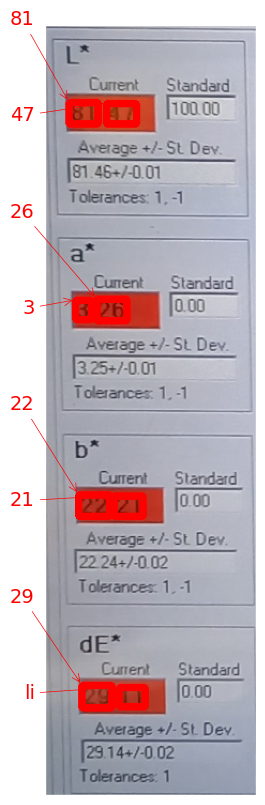

In [5]:
# Plot
fig, axs = plt.subplots(1, 1, figsize=(15, 10))
keras_results = kerasocr_df[['text','bbox']].values.tolist()
print(kerasocr_df.iloc[0]['bbox'])
keras_results = [(x[0], np.array(x[1])) for x in keras_results]
keras_ocr.tools.drawAnnotations(img, 
                                keras_results, ax=axs)
plt.show()